# Sweet Lift Taxi

Using historical data on taxi orders at airports this project will build a model that will predict the amount of taxi order for the next hour.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Preparation" data-toc-modified-id="Data-Preparation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Preparation</a></span><ul class="toc-item"><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></li><li><span><a href="#Data-Analysis" data-toc-modified-id="Data-Analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Analysis</a></span><ul class="toc-item"><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></li><li><span><a href="#Model-Training" data-toc-modified-id="Model-Training-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model Training</a></span><ul class="toc-item"><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Conclusion</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></li><li><span><a href="#Final-Conclusion" data-toc-modified-id="Final-Conclusion-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Final Conclusion</a></span></li></ul></div>

## Data Preparation

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import itertools
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

data=pd.read_csv('/datasets/taxi.csv',index_col=[0],parse_dates=[0])
display(data)
display(data.describe())
print(data.isnull().sum())



,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


num_orders    0
dtype: int64


### Conclusion
Pandas read_csv function is used to read the data, while the describe function is used to get an overview of the data, potentially spot any outliers. Using the isnull function,there are no missing values in the data.

## Data Analysis

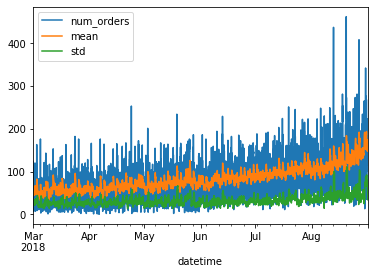

In [2]:
# resample 
data = data.resample('1H').sum()

# analyse the data 
data_w = data.copy()
data_w['mean'] = data_w['num_orders'].rolling(15).mean()
data_w['std'] = data_w['num_orders'].rolling(15).std()
data_w.plot()



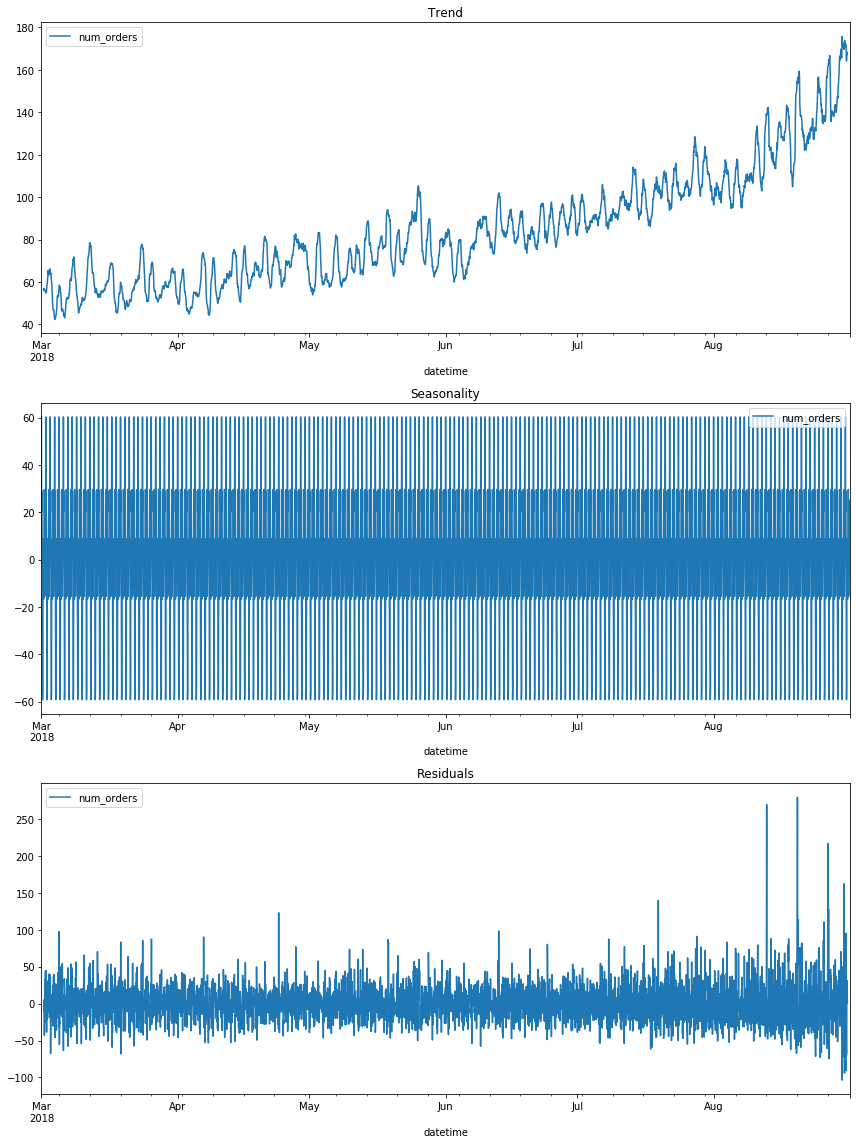

In [3]:
decomposed=seasonal_decompose(data)
plt.figure(figsize=(12, 16))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

### Conclusion
In order to complete analysis the resample function is used in order to split the data into hours. The first diagram shows that the mean number of orders is fairly constant until July, which is when the amount increases. This could be because August is when a significantly more people go on holiday, hence book a taxi. This is highlighted when the data is decomposed. The trend graph shows that from July onwards the graph as a fairly steep continious increase.

## Model Training

In [4]:
#  split data

def features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour']= data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = (
        data['num_orders'].shift().rolling(rolling_mean_size).mean())

features(data,6,15)
# make features and target

features=data.drop(['num_orders'],axis=1)
target= data['num_orders']

train,test = train_test_split(data, test_size=0.2, shuffle=False, random_state=12345)

train,val= train_test_split(train, test_size=0.25, shuffle=False, random_state=12345)

train=train.dropna()
test=test.dropna()
val = val.dropna()

features_tr=train.drop(['num_orders'],axis=1)
features_test=test.drop(['num_orders'],axis=1)
features_v = val.drop(['num_orders'],axis=1)

target_tr= train['num_orders']
target_test = test['num_orders']
target_v = val['num_orders']

### Conclusion
To create features for the forecast prediction the shift function is used as previous values in the time series will indicate whether the next value from the function x(t) will be an increase or decrease. Rolling mean function is then used to set the generak trend of the time series. As the shift function has been used, any missing values where dropped using dropna() once the data was split for train and test datasets.

In [8]:
model= LinearRegression()
model.fit(features_tr,target_tr)
predict=model.predict(features_v)
mse = mean_squared_error(target_v, predict)
rmse =  np.sqrt(mse)
print('RMSE Score: ',rmse)

RMSE Score:  33.27515678989114


In [ ]:
d_list=[]
for estimators, depth in itertools.product(range(10,101,10), range(1,11,1)):
    mo = RandomForestRegressor(random_state=12345,n_estimators=estimators,max_depth=depth)
    mo.fit(features_tr,target_tr)
    predicts=mo.predict(features_v)
    mse = mean_squared_error(target_v, predicts)
    rmse = np.sqrt(mse)
    d_list.append([rmse,estimators, depth])
    df_diag = pd.DataFrame(d_list, columns=['rmse','estimators', 'depth'])
print('RMSE:',df_diag.sort_values(by='rmse').head(5))

In [ ]:
ddf_list = []  
for dep in  range(1,11,1):
        models= DecisionTreeRegressor(random_state=12345,max_depth=dep)
        models.fit(features_tr,target_tr)
        prediction = models.predict(features_v)
        mse = mean_squared_error(target_v, prediction)
        rmse = np.sqrt(mse)
        ddf_list.append([rmse, depth])
        ddf_diag = pd.DataFrame(ddf_list, columns=['rmse', 'depth'])
print('RMSE:',ddf_diag.sort_values(by='rmse').head(5))

### Conclusion
Random forest regressor with hyperparameter depth 10 and estimator 30 has the best RMSE score for the training set at 26 RMSE. It also satisfies the condition that the RMSE score cannot be larger than 48. Linear Regression returns the worst performance with an RMSE score of 33 as its lowest score.

In [5]:
df_feat, df_tar = pd.concat([features_tr, features_v]), pd.concat([target_tr , target_v])

final_model=RandomForestRegressor(random_state=12345,n_estimators=30,max_depth=10)
final_model.fit(df_feat,df_tar)
predictions=final_model.predict(features_test)
mse = mean_squared_error(target_test, predictions)
rmse = np.sqrt(mse)
print('Test data RMSE:', rmse)

Test data RMSE: 45.29293934575516


## Final Conclusion
Following the results from the test data, the Random forest regressor model  is the best model to predict the number of orders per hour. It provides the lowest RMSE out of all the models tested and it still satisfies the condition that the RMSE must be no larger than 48.